# KEEP SECTION

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from itertools import chain
%matplotlib inline

In [ ]:
import scrapy
from tripadvisor.items import TripadvisorItem

class TrSpider(scrapy.Spider):
    name = 'trspider'
    start_urls = [
            'https://www.tripadvisor.com/Hotels-g29217-Island_of_Hawaii_Hawaii-Hotels.html'
            ]

    def parse(self, response):
        for href in response.xpath('//div[@class="listing_title"]/a/@href'):
            url = response.urljoin(href.extract())
            yield scrapy.Request(url, callback=self.parse_hotel)

        next_page = response.xpath('//div[@class="unified pagination standard_pagination"]/child::*[2][self::a]/@href')
        if next_page:
            url = response.urljoin(next_page[0].extract())
            yield scrapy.Request(url, self.parse)

    def parse_hotel(self, response):
        for href in response.xpath('//div[starts-with(@class,"quote")]/a/@href'):
            url = response.urljoin(href.extract())
            yield scrapy.Request(url, callback=self.parse_review)


        next_page = response.xpath('//link[@rel="next"]/@href')
        if next_page:
            url = response.urljoin(next_page[0].extract())
            yield scrapy.Request(url, self.parse_hotel)

    def parse_review(self, response):
        item = TripadvisorItem()
        item['headline'] = response.xpath('translate(//div[@class="quote"]/text(),"!"," ")').extract()[0][1:-1]
        item['review'] = response.xpath('translate(//div[@class="entry"]/p,"\n"," ")').extract()[0]
        item['bubbles'] = response.xpath('//span[contains(@class,"ui_bubble_rating")]/@alt').extract()[0]
        item['date'] = response.xpath('normalize-space(//span[contains(@class,"ratingDate")]/@content)').extract()[0]
        item['hotel'] = response.xpath('normalize-space(//span[@class="altHeadInline"]/a/text())').extract()[0]
        return item

In [3]:
df = pd.read_csv('bihotels.csv', dtype={'bubbles':'category','hotel':'category','review':'str'}, parse_dates=[1])
df.dropna(inplace=True)
df['rating'] = np.where((df['bubbles'] == '5 of 5 bubbles'), 1, 0)
df = df.groupby('hotel').filter(lambda x: len(x) > 100)
df['hotel'] = df['hotel'].cat.remove_unused_categories()
df.head()

,bubbles,date,headline,hotel,review,rating
0,5 of 5 bubbles,2017-07-19,Satisfied Beyond our expectations,"Fairmont Orchid, Hawaii",From the moment we arrived at the Fairmont or...,1
1,5 of 5 bubbles,2017-07-19,Honeymoon at the Fairmont,"Fairmont Orchid, Hawaii",We went there for our honeymoon and were wowe...,1
2,3 of 5 bubbles,2017-07-19,Travelguy,"Fairmont Orchid, Hawaii",Hotel is in a lovely remote location and is a...,0
3,4 of 5 bubbles,2017-06-29,Met our expectations,Wyndham Mauna Loa Village,"We stayed here for 7 nights, June 18-25, 2017...",0
4,5 of 5 bubbles,2017-06-27,Great hotel with amazing views,"Fairmont Orchid, Hawaii",My husband and I stayed here at the beginning...,1


In [4]:
pos_df = df[df['rating'] == 1]
pos_reviews = (pos_df['review']).tolist()

# TEST SECTION

In [5]:
pos_df = df[df['bubbles'] == '5 of 5 bubbles']

test = pos_df['review'][0:10000]

In [6]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = nltk.RegexpTokenizer(r'\w+')
token = test.apply(lambda x: tokenizer.tokenize(x.lower()))
token = token.apply(lambda x: [word for word in x if word not in stopwords])
token = list(chain.from_iterable(token))

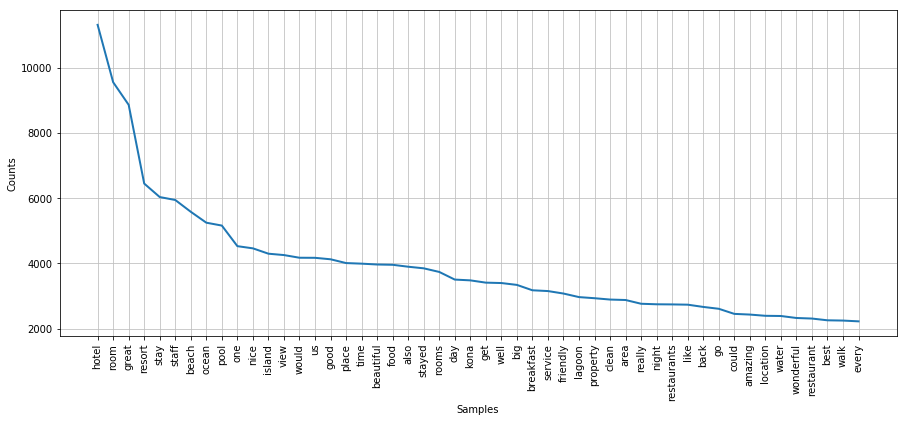

In [7]:
plt.figure(figsize=(15,6))
nltk.FreqDist(token).plot(50)

# OLD SNIPPETS

In [ ]:
def tokenizer(reviews):
    return [[token for token in nltk.word_tokenize(review.lower()) if token not in stopwords] 
            for review in reviews]

def frequencies(tokens):
    return[nltk.FreqDist(token) for token in tokens]